# Series de tiempo

Se procede a importar los datos de los commodities, obtenidos por DataSet de Kaggle y se analiza el precio de las materias primas a lo largo del tiempo.

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\all_fuels_data.csv
C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\Brent_Crude_Oil_data.csv
C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\Crude_Oil_data.csv
C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\Heating_Oil_data.csv
C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\Natural_Gas_data.csv
C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data\RBOB_Gasoline_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Step 1: Data Preparation
# Assuming your commodity dataset is stored in a CSV file named 'commodity_data.csv'
data = pd.read_csv('C:/Users/Johal/Documents/Uninorte/SeriesdeTiempo/MachineLearning/DataTarea1/individual_data/all_fuels_data.csv')
data['Date'] = pd.to_datetime(data['date'])
data.set_index('Date', inplace=True)

# Step 2: Exploratory Data Analysis (EDA)
# Descriptive Statistics
print(data.describe())

               open          high           low         close        volume
count  28075.000000  28075.000000  28075.000000  28075.000000  2.807500e+04
mean      27.288994     27.680580     26.873389     27.287224  1.059926e+05
std       36.085625     36.540236     35.599243     36.089001  1.484400e+05
min      -14.000000      0.507000    -40.320000    -37.630001  0.000000e+00
25%        2.031000      2.060550      1.998200      2.031250  2.641100e+04
50%        3.374000      3.450000      3.301000      3.375900  4.903300e+04
75%       54.895000     55.745001     53.910000     54.900000  1.147245e+05
max      146.080002    147.429993    144.270004    146.080002  2.288230e+06


In [3]:
data.head(-1)

,ticker,commodity,date,open,high,low,close,volume
Date,,,,,,,,
2000-08-23,CL=F,Crude Oil,2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,CL=F,Crude Oil,2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,CL=F,Crude Oil,2000-08-25,31.700001,32.099998,31.320000,32.049999,44601
2000-08-28,CL=F,Crude Oil,2000-08-28,32.040001,32.919998,31.860001,32.869999,46770
2000-08-29,CL=F,Crude Oil,2000-08-29,32.820000,33.029999,32.560001,32.720001,49131
...,...,...,...,...,...,...,...,...
2024-06-14,BZ=F,Brent Crude Oil,2024-06-14,82.139999,83.389999,81.919998,82.620003,39346
2024-06-17,BZ=F,Brent Crude Oil,2024-06-17,82.620003,84.550003,82.110001,84.250000,32978
2024-06-18,BZ=F,Brent Crude Oil,2024-06-18,84.400002,85.480003,83.660004,85.330002,45690


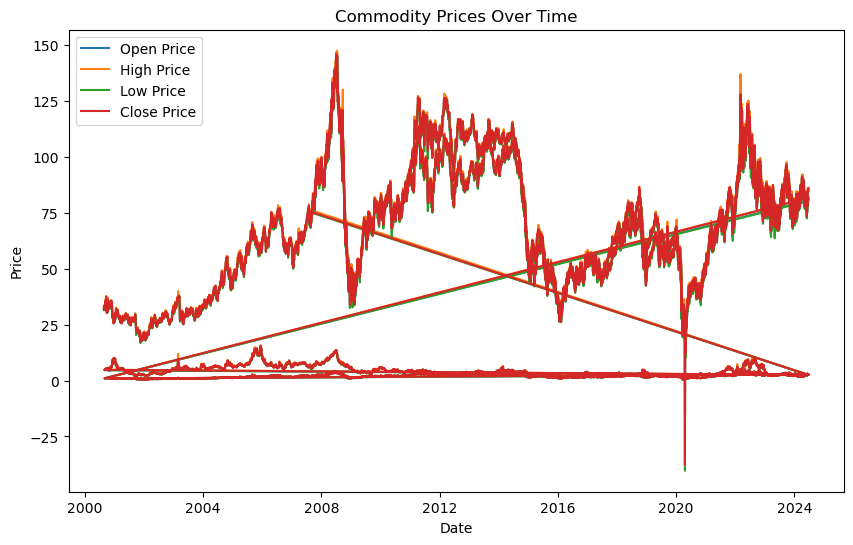

In [4]:
#Time Series Visualization
plt.figure(figsize=(10,6))
plt.plot(data.index, data['open'], label='Open Price')
plt.plot(data.index, data['high'], label='High Price')
plt.plot(data.index, data['low'], label='Low Price')
plt.plot(data.index, data['close'], label='Close Price')
plt.title('Commodity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

De la imagen anterior, podemos observar como las líneas de los precios se superponen entre sí, por lo que se deberá analizar el precio de cierre de cada commodity por separado. Para efectos del ejercicio, analizaremos el petróleo crudo y el gas natural.

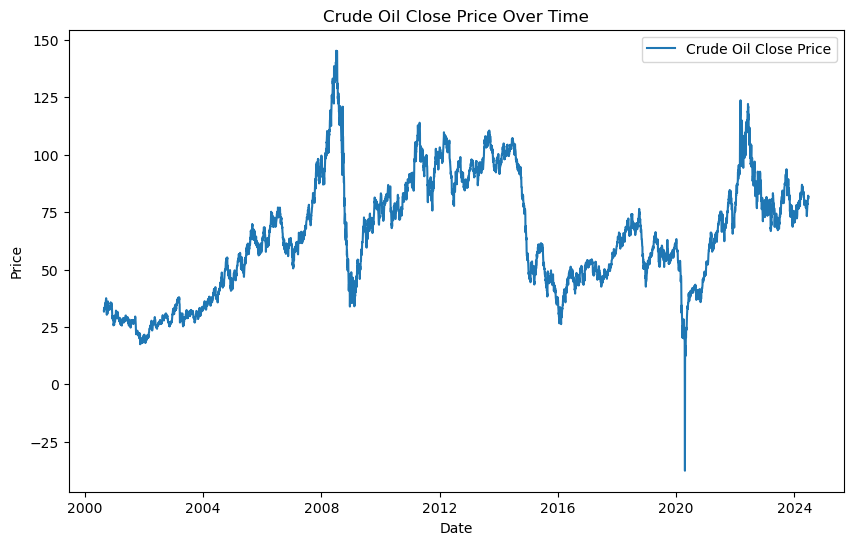

In [5]:
crude_oil_data = data[data['commodity'] == 'Crude Oil']
brent_crude_oil_data = data[data['commodity'] == 'Brent Crude Oil']
heating_oil_data=data[data['commodity'] == 'Heating Oil']
natural_gas_data=data[data['commodity'] == 'Natural Gas']
rbob_gasoline_data=data[data['commodity'] == 'RBOB Gasoline']

plt.figure(figsize=(10, 6))
plt.plot(crude_oil_data.index, crude_oil_data['close'], label='Crude Oil Close Price')
plt.title('Crude Oil Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
def sarima_forecast(data):
    # Stationarity Testing
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # Model Fitting
    sarima_model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
    sarima_result = sarima_model.fit()
    forecast_horizon=730
    # Forecasting
    forecast = sarima_result.predict(start=len(data), 
                                     end=len(data) + forecast_horizon - 1,  # Adjusted end index
                                     typ='levels')

    # Extend the index to include forecasted dates
    forecast.index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), 
                                   periods=forecast_horizon,  # Adjusted periods argument
                                   freq='D')
    return forecast, sarima_result

# Fit SARIMA model, forecast, and evaluate for Crude Oil
crude_oil_forecast, crude_oil_model = sarima_forecast(crude_oil_data['close'])

ADF Statistic: -2.7548529467181466
p-value: 0.0650176871568625


c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

Se aplica el modelo SARIMA para predecir el precio del petróleo crudo. 

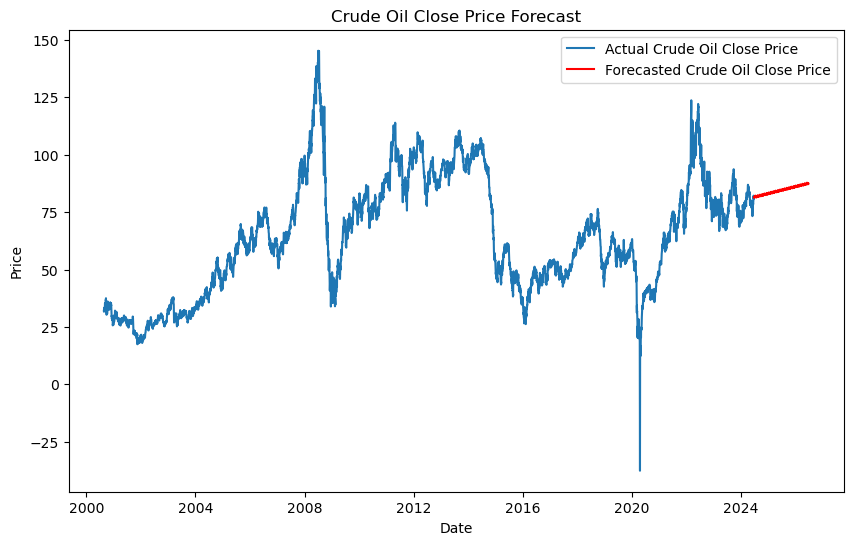

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(crude_oil_data.index, crude_oil_data['close'], label='Actual Crude Oil Close Price')
plt.plot(crude_oil_forecast.index, crude_oil_forecast, label='Forecasted Crude Oil Close Price', color='red')
plt.title('Crude Oil Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

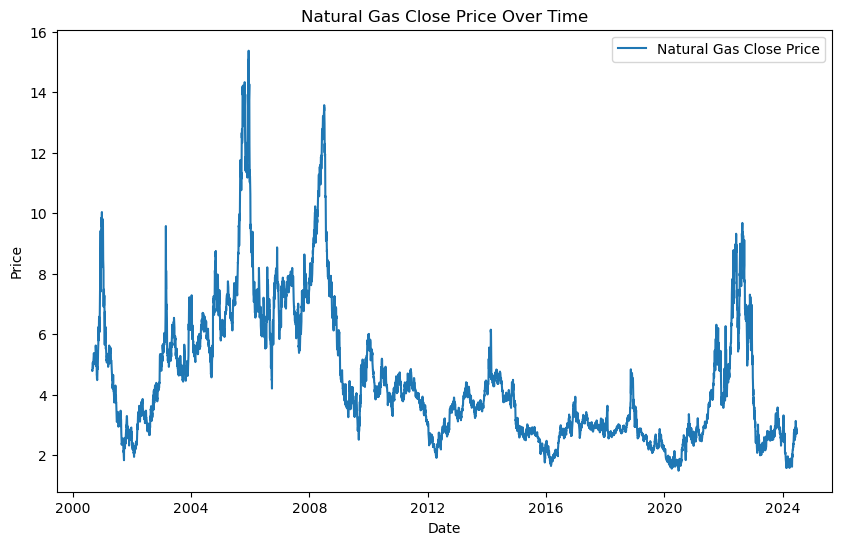

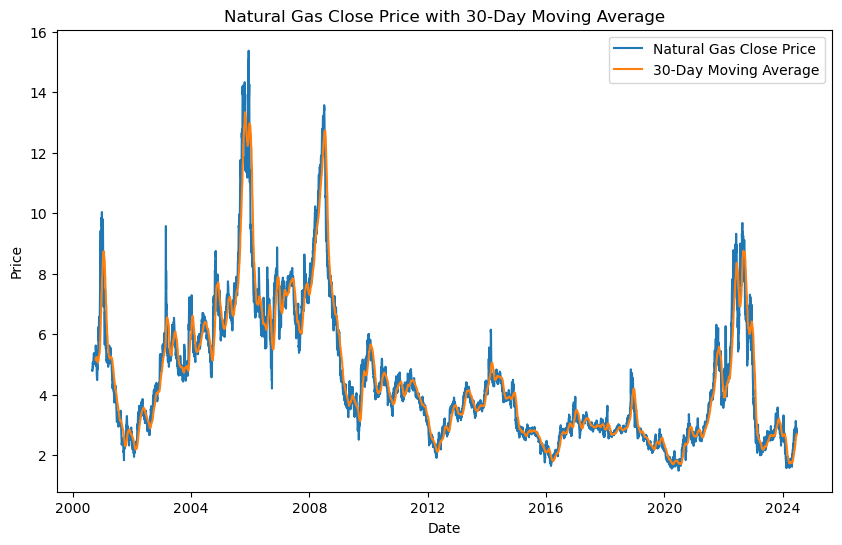

ADF Statistic: -3.0372618855301416
p-value: 0.03155811387757923


c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Johal\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

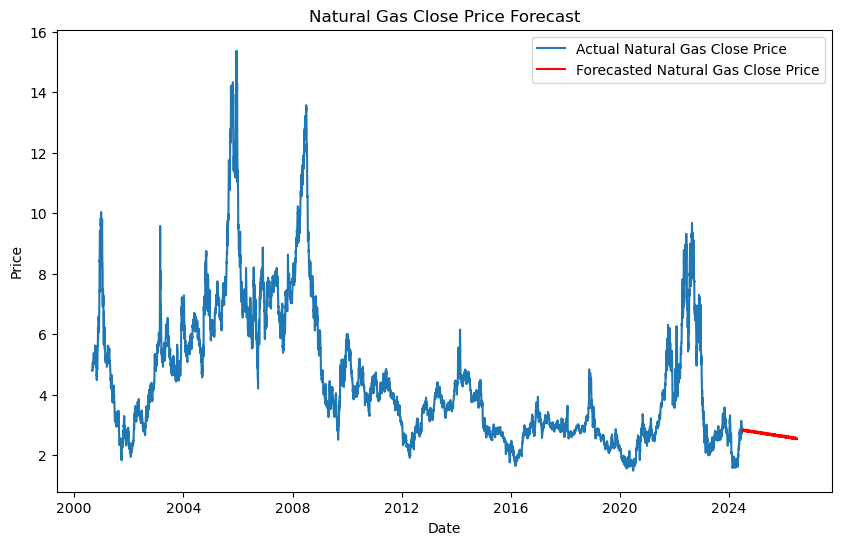

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(natural_gas_data.index, natural_gas_data['close'], label='Natural Gas Close Price')
plt.title('Natural Gas Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

rolling_mean_natural_gas = natural_gas_data['close'].rolling(window=30).mean()
plt.figure(figsize=(10, 6))
plt.plot(natural_gas_data.index, natural_gas_data['close'], label='Natural Gas Close Price')
plt.plot(rolling_mean_natural_gas.index, rolling_mean_natural_gas, label='30-Day Moving Average')
plt.title('Natural Gas Close Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


natural_gas_forecast, natural_gas_model = sarima_forecast(natural_gas_data['close'])

plt.figure(figsize=(10, 6))
plt.plot(natural_gas_data.index, natural_gas_data['close'], label='Actual Natural Gas Close Price')
plt.plot(natural_gas_forecast.index, natural_gas_forecast, label='Forecasted Natural Gas Close Price', color='red')
plt.title('Natural Gas Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()